## Solución

### Imports

In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

### Cargar imágenes en escala de grises

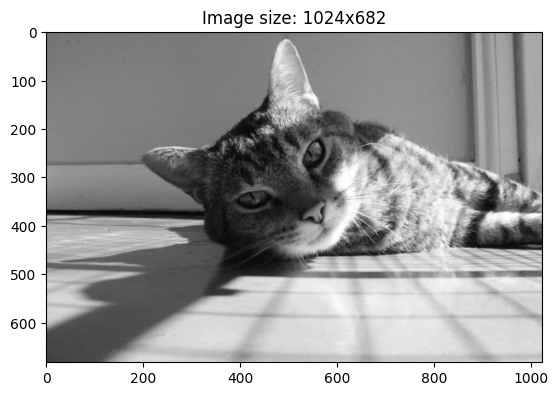

In [2]:
def load_grayscale_image(file_path):
    # Cargar imagen en escala de grises
    image = Image.open(file_path).convert('L')

    # Convertir la imagen de PIL a tensor de PyTorch
    transform = transforms.ToTensor()
    img_tensor = transform(image)

    # Eliminar la dimensión adicional y convertirla a un tensor 2D
    img_tensor = img_tensor.squeeze(0)

    return img_tensor

img_tensor = load_grayscale_image('Cat.jpg')

plt.subplot()
plt.imshow(img_tensor.numpy(), cmap='gray')
plt.title(f'Image size: {img_tensor.shape[1]}x{img_tensor.shape[0]}')

print()

### Precálculo de las tablas de puntos cercanos

In [3]:
def calc_coordinates_grid(rows, cols, alpha):
    # Indices por fila y columna de la imagen escalada
    row_indexes, col_indexes = torch.arange(rows), torch.arange(cols)

    # Calcular la posicion relativa de los indices originales en tensores con las nuevas dimensiones
    rel_rows = row_indexes.float() / alpha
    rel_cols = col_indexes.float() / alpha

    # Convertir flotantes a enteros para obtener los indices mas cercanos por punto en la imagen original
    nearest_i = rel_rows.floor().long()
    nearest_j = rel_cols.floor().long()

    # Construir dos matrices (rows x cols) de indices i / j para indexar la imagen escalada
    grid_i, grid_j = torch.meshgrid(row_indexes, col_indexes, indexing='ij')

    # Mapear los indices mas cercanos a la matriz de indices respectiva para saber, por cada punto,
    # cuales son los indices i y j mas cercanos en la imagen original
    nearest_i_grid = nearest_i[grid_i]
    nearest_j_grid = nearest_j[grid_j]

    return nearest_i_grid, nearest_j_grid

new_rows, new_cols, alpha = 6, 6, 2
nearest_i_grid, nearest_j_grid = calc_coordinates_grid(new_rows, new_cols, alpha)

print(f'nearest_i_grid:\n{nearest_i_grid}\n')
print(f'nearest_j_grid:\n{nearest_j_grid}')

nearest_i_grid:
tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2]])

nearest_j_grid:
tensor([[0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2]])


### Cálculo del escalado

In [5]:
"""
file_path: Ruta del archivo sobre el que se aplicará el escalado
alpha: Factor de escalado de la nueva imagen respecto a la original
"""
def scale_image(file_path, alpha):
    # Cargar la imagen y sus dimensiones originales
    img_tensor = load_grayscale_image(file_path)
    rows, cols = img_tensor.shape

    # Calcular las nuevas dimensiones y crear la base de la nueva imagen
    new_rows, new_cols = rows * alpha, cols * alpha
    img_tensor_scaled = torch.zeros((new_rows, new_cols))
    
    # Obtener tablas de puntos cercanos
    nearest_i_grid, nearest_j_grid = calc_coordinates_grid(new_rows, new_cols, alpha)
    
    # Iterar sobre toda la imagen para calcular los valores con los que completarla
    count = 0
    for i in range(new_rows):
        for j in range(new_cols):
            count = count + 1
            print(f'Pasos restantes --> {new_rows*new_cols - count}', end='\r')

            # Copiar el valor de la imagen original si (i, j) corresponde a un punto original
            if i % alpha == 0 and j % alpha == 0:
                img_tensor_scaled[i, j] = img_tensor[i // alpha, j // alpha]
            else:
                # Recuperar los 3 puntos más cercanos, iniciando con el vecino por tabla
                r1, c1 = nearest_i_grid[i, j], nearest_j_grid[i, j]
                # Vecino vertical / Cubrir posible desface
                r2, c2 = min(r1 + 1, rows - 1), c1
                # Vecino horizontal / Cubrir posible desface
                r3, c3 = r1, min(c1 + 1, cols - 1)

                # Construir la matriz A con las coordenadas de los 3 puntos
                A = torch.tensor([[r1, c1, 1.0], [r2, c2, 1.0], [r3, c3, 1.0]])
                # Construir el vector z con los valores de intensidad de los 3 puntos
                z = torch.tensor([img_tensor[r1, c1], img_tensor[r2, c2], img_tensor[r3, c3]])

                # Calcular la pseudo-inversa de A para iniciar la solucion del sistema
                A_pseudo_inv = torch.linalg.pinv(A)
                # Calcular los coeficientes del plano estimado
                coefficients = torch.matmul(A_pseudo_inv, z)

                # Calcular el valor estimado en la posición (i, j) y asignarlo
                x_n, y_n = i / alpha, j / alpha
                z_n = coefficients[0] * x_n + coefficients[1] * y_n + coefficients[2]
                img_tensor_scaled[i, j] = z_n

    # Mostrar la imagen original y la escalada con interpolación bilineal
    plt.figure(figsize=(12, 6))

    # Imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(img_tensor.numpy(), cmap='gray')
    plt.title('Imagen Original en Escala de Grises')

    # Imagen escalada
    plt.subplot(1, 2, 2)
    plt.imshow(img_tensor_scaled.numpy(), cmap='gray')
    plt.title('Imagen Escalada con Interpolación Bilineal (3 Puntos)')
    plt.show()

    print(f'Tamaño original: {img_tensor.shape} Tamaño luego del escalado: {img_tensor_scaled.shape}')

U = torch.tensor([[1, 5, 7],
                  [3, 1, 2],
                  [2, 1, 5]], dtype=torch.float32)

### Ejercicios

#### Usando $\alpha = 2$

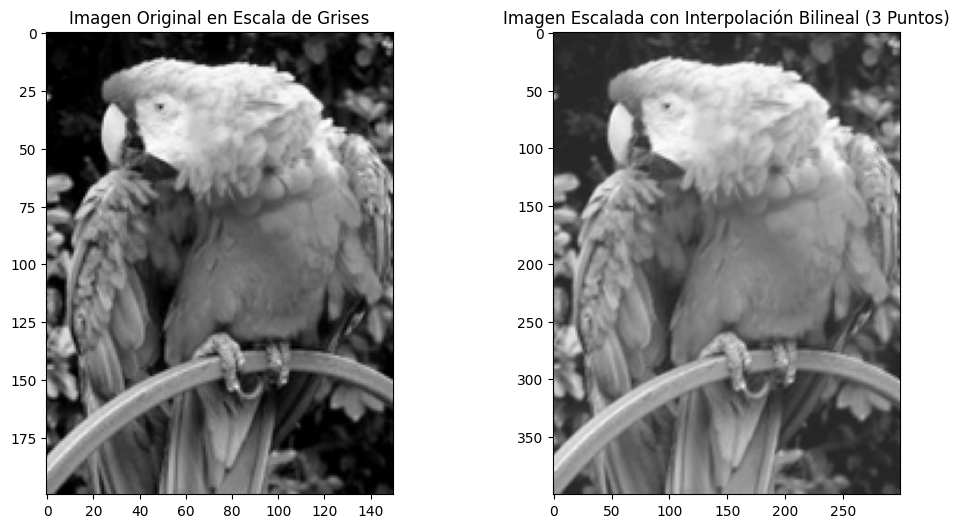

Tamaño original: torch.Size([200, 150]) Tamaño luego del escalado: torch.Size([400, 300])


In [99]:
scale_image('Parrot.png', 2)

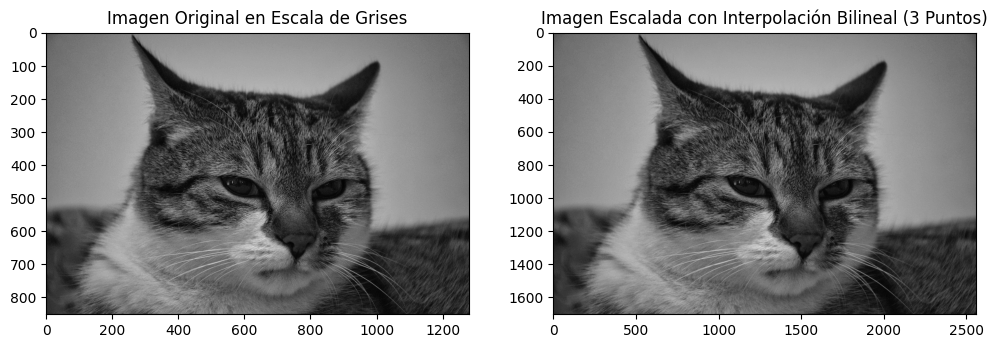

Tamaño original: torch.Size([853, 1280]) Tamaño luego del escalado: torch.Size([1706, 2560])


In [7]:
scale_image('Cat2.jpg', 2)

#### Usando $\alpha = 3$

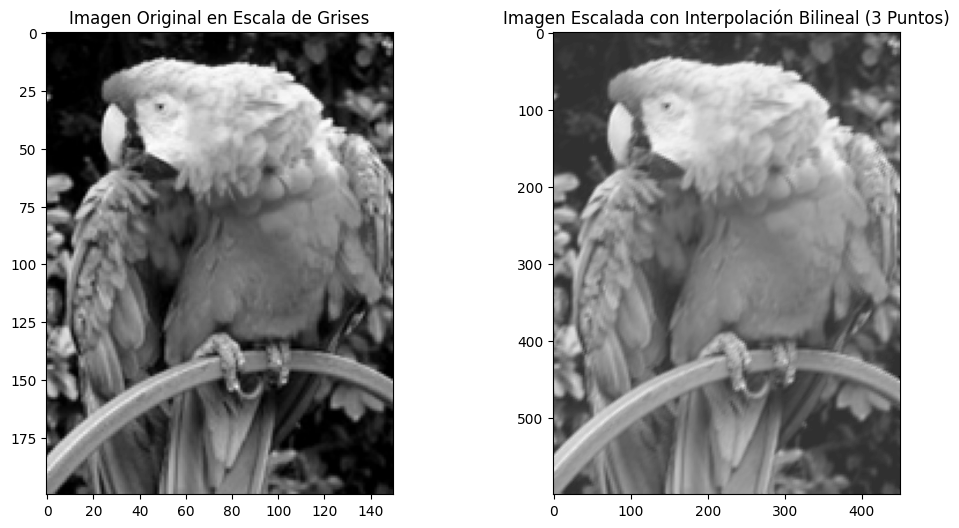

Tamaño original: torch.Size([200, 150]) Tamaño luego del escalado: torch.Size([600, 450])


In [100]:
scale_image('Parrot.png', 3)

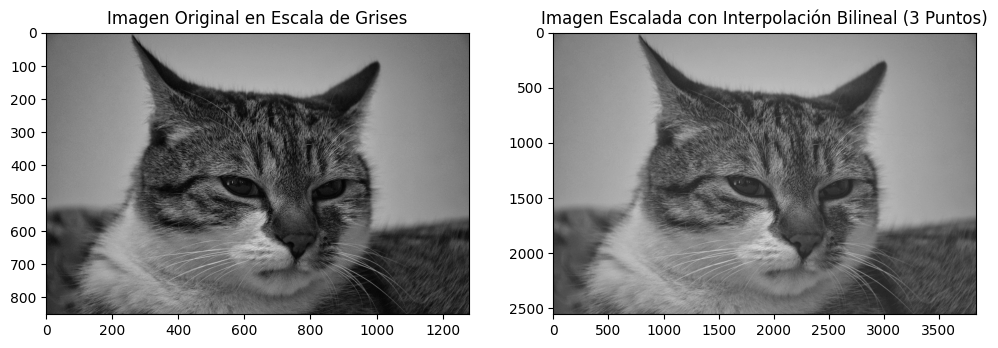

Tamaño original: torch.Size([853, 1280]) Tamaño luego del escalado: torch.Size([2559, 3840])


In [8]:
scale_image('Cat2.jpg', 3)